## Convolutional Kolmogorov-Arnold Networks

Load thư viện và các model cần thiết

In [26]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, transforms
# import numpy as np
# import matplotlib.pyplot as plt


# from architectures_28x28.SimpleModels import *
# from architectures_28x28.KKAN import KKAN_Convolutional_Network

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from torch.utils.data import DataLoader

from architectures_28x28.CKAN_BN import CKAN_BN
from architectures_28x28.SimpleModels import *
from architectures_28x28.ConvNet import ConvNet
from architectures_28x28.KANConvs_MLP import KANC_MLP
from architectures_28x28.KKAN import KKAN_Convolutional_Network
from architectures_28x28.conv_and_kan import NormalConvsKAN


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [60]:
kkan_model = KKAN_Convolutional_Network()
# kkan_model.to(device)
kkan_model.load_state_dict(torch.load('models/KKAN_Convolutional/best_model.pth',weights_only=True))
kkan_model.eval()  

KKAN_Convolutional_Network(
  (conv1): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0-4): 5 x KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (conv2): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0-4): 5 x KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (kan1): KANLinear(
    (base_activation): SiLU()
  )
)

In [ ]:
import torch

# Load the model (assuming it was saved previously)
model_path = 'path_to_kkan_model.pth'
kkan_model = torch.load(model_path)

# Check the device of model parameters
def check_model_device(model):
    for name, param in model.named_parameters():
        print(f"Parameter {name} is on device: {param.device}")
        break  # Print the device of the first parameter only for brevity

check_model_device(kkan_model)

# Output the device for all parameters (optional)
def check_all_parameters_device(model):
    for name, param in model.named_parameters():
        print(f"Parameter {name} is on device: {param.device}")

# Uncomment to check all parameters
# check_all_parameters_device(kkan_model)


In [51]:
ckan = NormalConvsKAN()
ckan.to(device)
ckan.load_state_dict(torch.load('models/NormalConvsKAN/best_model.pth',weights_only=True))
ckan.eval()  

NormalConvsKAN(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (kan1): KANLinear(
    (base_activation): SiLU()
  )
)

In [29]:
modelCNN = SimpleCNN_2()
modelCNN.to()
modelCNN.load_state_dict(torch.load('models/SimpleCNN_2/best_model.pth', weights_only=True))
modelCNN.eval()  # Đặt mô hình ở chế độ đánh giá

SimpleCNN_2(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(5, 25, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=625, out_features=245, bias=True)
  (fc2): Linear(in_features=245, out_features=10, bias=True)
)

In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)


Data device: cpu, Target device: cpu
Output device: cpu
Predicted: 4, Actual: 4


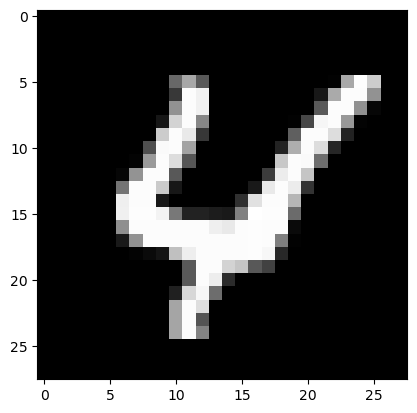

In [63]:
def predictFirstNumber(model, device, test_loader):
    # model.to(device)
    model.eval()
   

    with torch.no_grad():
        for data, target in test_loader:
            # data, target = data.to(device), target.to(device)
            print(f"Data device: {data.device}, Target device: {target.device}")

            output = model(data)
            print(f"Output device: {output.device}")
            pred = output.argmax(dim=1, keepdim=True)
            print(f'Predicted: {pred.item()}, Actual: {target.item()}')

            plt.imshow(data.cpu().squeeze().numpy(), cmap='gray')
            plt.show()
            break  

# predictFirstNumber(ckan, device, test_loader)

predictFirstNumber(kkan_model, device, test_loader)


In [20]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels)
            all_preds.extend(predicted)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy, all_labels, all_preds

In [21]:
print(len(test_dataset))

10000


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [25]:
cnn_accuracy, cnn_labels, cnn_preds = evaluate_model(modelCNN, test_loader)
print(f'CNN Model Accuracy: {cnn_accuracy * 100:.2f}%')

CNN Model Accuracy: 97.88%


cKAN Model Accuracy: 61.25%


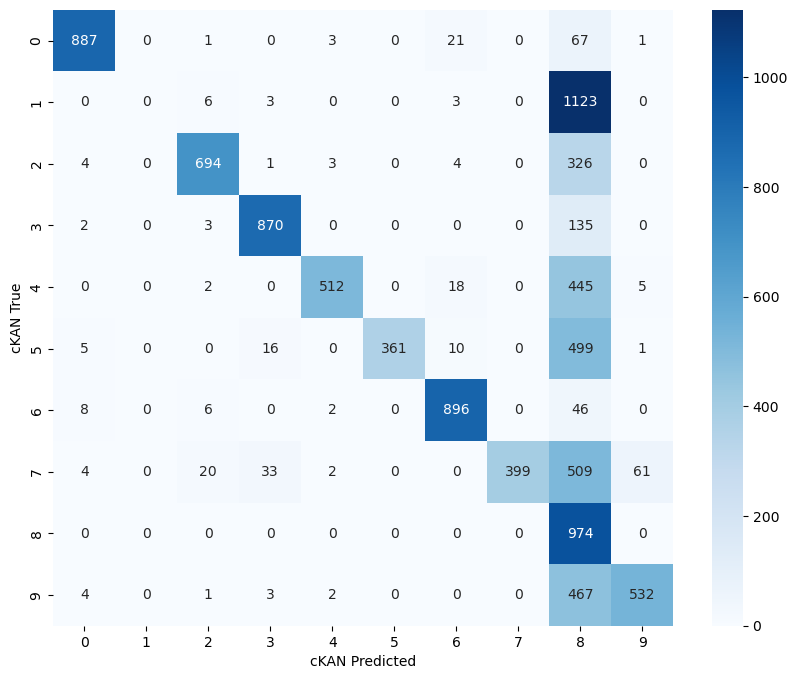

In [31]:
ckan_accuracy, ckan_labels, ckan_preds = evaluate_model(kkan_model, test_loader)
print(f'cKAN Model Accuracy: {ckan_accuracy * 100:.2f}%')
ckan_cm = confusion_matrix(ckan_labels, ckan_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(ckan_cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('cKAN Predicted')
plt.ylabel('cKAN True')
plt.show()
